In [277]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

In [278]:
random.seed(42)
np.random.seed(42)

In [279]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

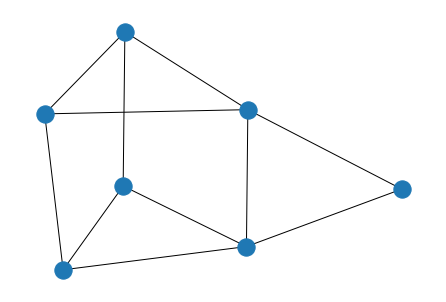

In [280]:

n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

In [281]:
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [282]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]

    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep].item(), pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep].item(), i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ



In [283]:

cell = torch.nn.LSTM(3,2,1)


graph_cost_list = [get_expectation(g,1) for g in graphs]

In [284]:
from statistics import mean
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    
    # Concatenate the previous parameters and previous cost to create new input
    prev_params=torch.reshape(prev_params,shape=(1,2))
    repeat_vals = [prev_cost.shape[0] // prev_params.shape[0]] + [-1] * (len(prev_params.shape) - 1)
    new_input = torch.cat((prev_cost, prev_params.expand(*repeat_vals)), dim=-1)

    new_input=torch.reshape(new_input, shape=(1,1,3))
    prev_h=torch.reshape(prev_h, shape=(1,1,2))
    prev_c=torch.reshape(prev_c, shape=(1,1,2))
     # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    new_params, (new_h, new_c) = cell(new_input, (prev_h, prev_c))
   # Reshape the parameters to correctly match those expected by PennyLane
    _params = torch.reshape(new_params, shape=(2, n_layers))
                                      
    # Evaluate the cost using new angles
    _cost = graph_cost(_params)

    # Reshape to be consistent with other tensors
    _cost=torch.tensor(_cost)
    new_cost = torch.reshape(_cost, shape=(1, 1))
    return [new_cost, new_params, new_h, new_c]

In [285]:
def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = torch.zeros(1, 1)
    #need shape=?
    initial_params = torch.zeros(1, 2 * n_layers)
    initial_h = torch.zeros(1, 2 * n_layers)
    initial_c = torch.zeros(1, 2 * n_layers)

    # We perform five consecutive calls to 'rnn_iteration', thus creating the
    # recurrent loop. More iterations lead to better results, at the cost of
    # more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)

    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    loss = torch.mean(torch.stack(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]])
    )
    #torch.mean(torch.stack(my_list))
    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

In [286]:
def train_step(graph_cost):
    """Single optimization step in the training procedure."""
    
    loss = recurrent_loop(graph_cost)
    loss.requires_grad=True
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss
    


In [287]:
# Select an optimizer
for param in cell.parameters():
    param.requires_grad = True
opt = optim.Adam(cell.parameters(), lr=0.1)


# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):

        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.detach().numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            loss=loss.detach().numpy()
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")


Epoch 1
 > Graph 1/20 - Loss: -1.654902458190918
 > Graph 6/20 - Loss: -1.0300781726837158
 > Graph 11/20 - Loss: -1.0406835079193115
 > Graph 16/20 - Loss: -0.8824023008346558
 >> Mean Loss during epoch: -1.4015722930431367
Epoch 2
 > Graph 1/20 - Loss: -1.654902458190918
 > Graph 6/20 - Loss: -1.0300781726837158
 > Graph 11/20 - Loss: -1.0406835079193115
 > Graph 16/20 - Loss: -0.8824023008346558
 >> Mean Loss during epoch: -1.4015722930431367
Epoch 3
 > Graph 1/20 - Loss: -1.654902458190918
 > Graph 6/20 - Loss: -1.0300781726837158
 > Graph 11/20 - Loss: -1.0406835079193115
 > Graph 16/20 - Loss: -0.8824023008346558
 >> Mean Loss during epoch: -1.4015722930431367
Epoch 4
 > Graph 1/20 - Loss: -1.654902458190918
 > Graph 6/20 - Loss: -1.0300781726837158
 > Graph 11/20 - Loss: -1.0406835079193115
 > Graph 16/20 - Loss: -0.8824023008346558
 >> Mean Loss during epoch: -1.4015722930431367
Epoch 5
 > Graph 1/20 - Loss: -1.654902458190918
 > Graph 6/20 - Loss: -1.0300781726837158
 > Graph 

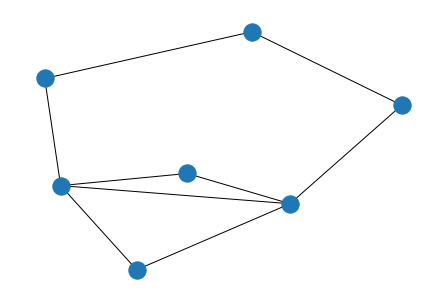

In [315]:
new_graph = nx.gnp_random_graph(7, p=3 / 7)
new_cost =get_expectation(new_graph,1)

nx.draw(new_graph)

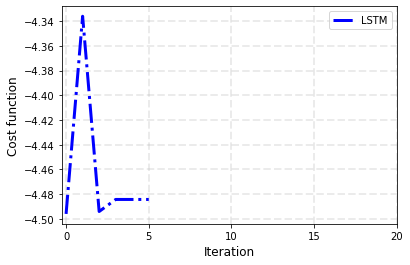

In [316]:
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = torch.zeros(2, 1)
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(torch.reshape(guess, (2, 1))) for guess in guesses]

fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

In [317]:
# Parameters are randomly initialized
x = torch.tensor(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = torch.optim.SGD(model.parameters(), lr=.01, momentum=0.9)
step = 15

# Training process
steps = []
sdg_losses = []
for _ in range(step):
    loss = recurrent_loop(graph_cost)
    loss.requires_grad=True
    opt.zero_grad()
    loss.backward()
    opt.step()

    steps.append(x.numpy())
    sdg_losses.append(loss.detach().numpy())

    print(f"Step {_+1} - Loss = {loss}")

print(f"Final cost function: {new_cost(x)}\nOptimized angles: {x}")



Step 1 - Loss = -1.3524609804153442
Step 2 - Loss = -1.3524609804153442
Step 3 - Loss = -1.3524609804153442
Step 4 - Loss = -1.3524609804153442
Step 5 - Loss = -1.3524609804153442
Step 6 - Loss = -1.3524609804153442
Step 7 - Loss = -1.3524609804153442
Step 8 - Loss = -1.3524609804153442
Step 9 - Loss = -1.3524609804153442
Step 10 - Loss = -1.3524609804153442
Step 11 - Loss = -1.3524609804153442
Step 12 - Loss = -1.3524609804153442
Step 13 - Loss = -1.3524609804153442
Step 14 - Loss = -1.3524609804153442
Step 15 - Loss = -1.3524609804153442
Final cost function: -4.484375
Optimized angles: tensor([[0.9297],
        [0.8081]], dtype=torch.float64)


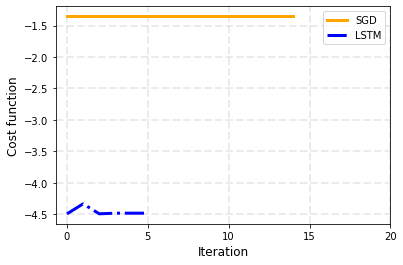

In [318]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color="orange", lw=3, label="SGD")

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()